In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2015600.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 164680.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 967852.33it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 8218519.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([60000, 28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,

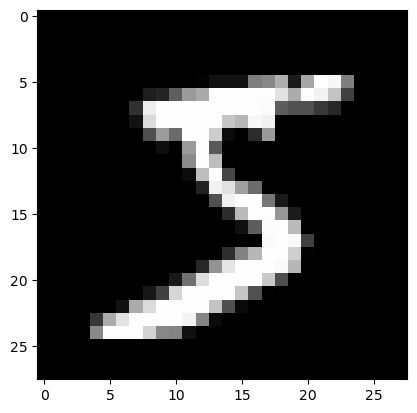

In [22]:
print(train_dataset.data.shape)
# 첫번째 데이터 출력
print(train_dataset.data[0])
# matplot 으로 출력
plt.imshow(train_dataset.data[0], cmap="gray")
print(train_dataset.targets[0])
plt.show()

In [23]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), nn.ReLU(True), nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super(Decoder, self).__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [24]:
encoder = Encoder(encoded_space_dim=2, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=2, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {"params": encoder.parameters()},
    {"params": decoder.parameters()},
]

optimizer = optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = nn.MSELoss()
print(encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [25]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0.0, 1.0)
    return noisy

torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


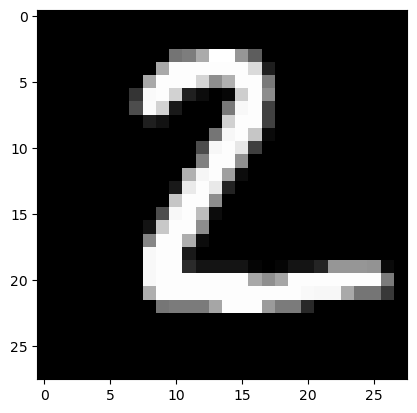

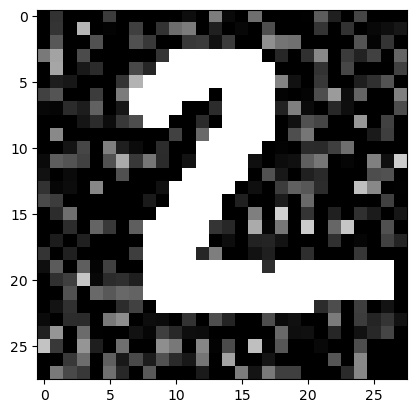

In [26]:
img = test_dataset.data[1].unsqueeze(0).float().to(device)
print(test_dataset.data[1].shape)
print(img.shape)
noisy_img = add_noise(img, noise_factor=0.3).to(device)
print(noisy_img.shape)
plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
plt.show()
plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap="gray")
plt.show()
rec_img = decoder(
    encoder(test_dataset.data[0].float().to(device).reshape(1, 1, 28, 28))
)
rec_img = decoder(encoder(noisy_img.reshape(1, 1, 28, 28)))

In [27]:
def plot_ae_outputs(encoder, decoder, n=15, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        img = test_dataset.data[i].unsqueeze(0).float().to(device)
        noisy_img = add_noise(img, noise_factor).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(noisy_img.reshape(-1, 1, 28, 28)))
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Noisy Input")

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed Input")
        plt.subplots_adjust(
            left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3
        )
    plt.show()

In [28]:
def train_epoch(
    encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3
):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        noisy_batch = add_noise(image_batch, noise_factor)
        encoded_data = encoder(noisy_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [29]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            noisy_batch = add_noise(image_batch, noise_factor)
            encoded_data = encoder(noisy_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [30]:
num_epochs = 30
history_da = {"train_loss": [], "test_loss": []}
loss_fn = nn.MSELoss()
for epoch in range(num_epochs):
    print("EPOCHE %d/%d" % (epoch + 1, num_epochs))
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        noise_factor=0.3,
    )
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn,
        noise_factor=0.3,
    )
    history_da["train_loss"].append(train_loss)
    history_da["test_loss"].append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(encoder=encoder, decoder=decoder, noise_factor=0.3)

EPOCHE 1/30


KeyboardInterrupt: 

[0.7362131865085972, -0.8336742868210263]


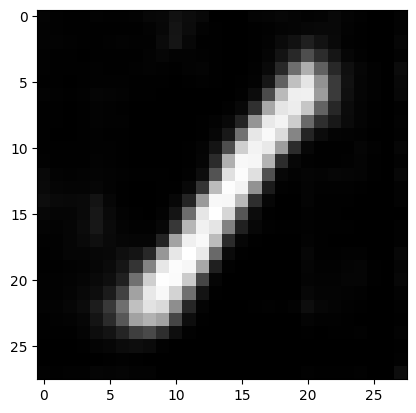

In [ ]:
# 임의의 숫자를 넣어서 random 으로 decoder 만으로 숫자 그림 생성하기
import random

random_data = [random.random() * 2 - 1 for _ in range(2)]
# random_data = [0.337, 0.49]
print(random_data)
output = decoder(torch.Tensor(random_data).to(device).reshape(-1, 2))
plt.imshow(output.cpu().squeeze().detach().numpy(), cmap="gray")
plt.show()

In [ ]:
# train data 로 숫자 얻기
for i in range(10):
    output = encoder(train_dataset.data[i].float().to(device).reshape(1, 1, 28, 28))
    print(train_dataset.targets[i])
    print(output)

tensor(5)
tensor([[-0.2937, -0.0568]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0)
tensor([[-1.4202,  1.4741]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(4)
tensor([[0.3951, 1.1770]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[ 0.1161, -0.1165]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(9)
tensor([[0.3552, 0.4243]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2)
tensor([[ 0.1076, -1.0921]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[ 0.4377, -0.0127]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(3)
tensor([[-0.2711, -0.0906]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[ 0.4554, -0.0114]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(4)
tensor([[0.1645, 0.1385]], device='cuda:0', grad_fn=<AddmmBackward0>)


## VAE

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [32]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [33]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyRelu = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyRelu(self.input1(x))
        h_ = self.LeakyRelu(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyRelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyRelu(self.hidden1(x))
        h = self.LeakyRelu(self.hidden2(h))
        return torch.sigmoid(self.output(h))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [34]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [40]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:

!pip install tensorboardX
# 6 model train function
from tensorboardX import SummaryWriter
saved_loc = "scalar/"
writer = SummaryWriter(saved_loc)

model.train()

Defaulting to user installation because normal site-packages is not writeable


Model(
  (Encoder): Encoder(
    (input1): Linear(in_features=784, out_features=400, bias=True)
    (input2): Linear(in_features=400, out_features=400, bias=True)
    (mean): Linear(in_features=400, out_features=200, bias=True)
    (var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (hidden1): Linear(in_features=200, out_features=400, bias=True)
    (hidden2): Linear(in_features=400, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2)
  )
)

In [37]:
model.train()


def train(epoch, model, train_loder, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loder):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar(
            "Train/Reconstruction Error",
            BCE.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        writer.add_scalar(
            "Train/KL-Divergence",
            KLD.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        writer.add_scalar(
            "Train/Total Loss",
            loss.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(x)}/{len(train_loder.dataset)} ({100. * batch_idx / len(train_loder):.0f}%)]\tLoss: {loss.item() / len(x):.6f}"
            )
    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loder.dataset)
        )
    )

In [38]:
import torchvision


# 7 model test function
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            writer.add_scalar(
                "Test/Reconstruction Error",
                BCE.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            writer.add_scalar(
                "Test/KL-Divergence",
                KLD.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            writer.add_scalar(
                "Test/Total Loss",
                loss.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())
                writer.add_image(
                    "Test image - Above: real data, below: reconstructed data",
                    grid,
                    epoch,
                )

In [ ]:
# 8 model train and test
from tqdm.auto import tqdm

for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 546.614570
